# Load necessary imports and data

In [1]:
# Imports

from scipy.io import loadmat
from scipy.stats import binned_statistic
import numpy as np
import seaborn as sns
from ripser import ripser
import matplotlib.pyplot as plt

In [2]:
# Load data file
# Obtained from https://crcns.org/data-sets/thalamus/th-1/about-th-1. Peyrache, A., Petersen P., Buzsáki, G. (2015). Extracellular recordings from multi-site silicon
# probes in the anterior thalamus and subicular formation of freely moving mice. CRCNS.org. http://dx.doi.org/10.6080/K0G15XS1
# With extraction of awake data thanks to Erik Hermansen and Ben Dunn

data = loadmat('data_files/Mouse12-120806_stuff_simple_awakedata.mat')

# Explore the data file

In [3]:
# List the keys of the data file
# Note tracking times are in ms
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cellnames', 'cellspikes', 'trackingtimes', 'headangle', 'position'])

In [4]:
# Load the data into Python variables
cellnames = data['cellnames']
cellspikes = data['cellspikes'][0]
headangle = data['headangle'][0]


trackingtimes = data['trackingtimes'][0]

# This is four columns: two each for a red LED and a blue LED. We'll load the first two columns. A value of -1 indicated LED detection failed. See 
# https://crcns.org/files/data/th-1/crcns_th-1_data_description.pdf for further details
position = data['position'][:, :2]

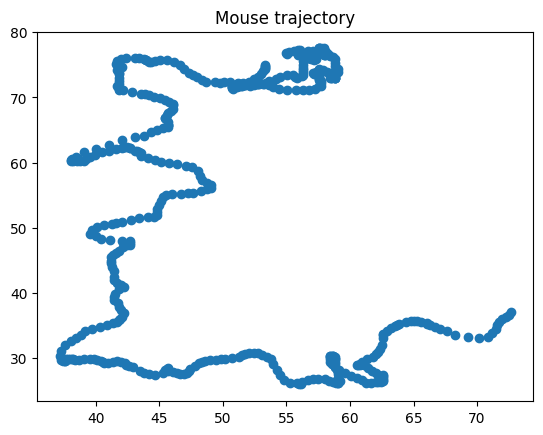

In [12]:
# Plot a subset of the trajectory
time_from = 100
time_to = 600

fig, ax = plt.subplots()
ax.scatter(position[time_from:time_to, 0], position[time_from:time_to, 1])
ax.set_title('Mouse trajectory')
plt.show()

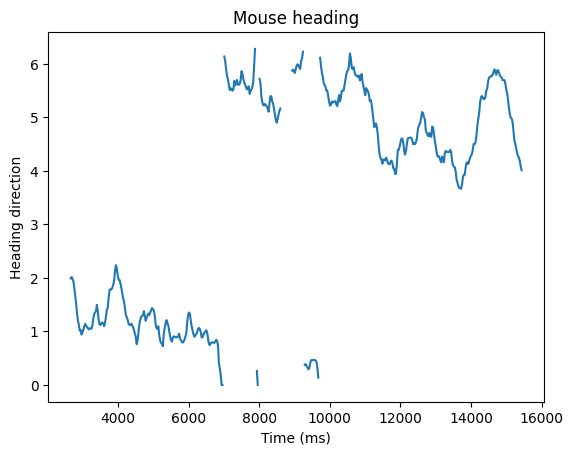

In [13]:
# Plot a subset of the headangle
time_from = 100
time_to = 600
length_heading_plot = time_to - time_from

# Note that tracking times are in ms and recorded every 25.6ms
xs_for_plot = [time_from + 25.6*x for x in range(time_from, time_to)]

headangle_to_plot = headangle[time_from:time_to]

# Set points of discontinuity (angle measured in radians) to NaN for plotting reasons
diffs = np.diff(headangle_to_plot)
discontinuities = np.where(np.abs(diffs) > 1)[0]
headangle_to_plot[discontinuities+1] = np.NaN

fig, ax = plt.subplots()

ax.plot(xs_for_plot, headangle_to_plot)

ax.set_ylabel('Heading direction')
ax.set_xlabel('Time (ms)')
ax.set_title('Mouse heading')
plt.show()

In [14]:
# Explore a single neuron's response

cell_index = 25

sample_spikes = cellspikes[cell_index][0]

In [15]:
# Note that spikes were recorded at 20kHz. So, each whole number below is 1ms.

sample_spikes

array([6881661.3 , 6881673.05, 6881686.45, ..., 9069728.85, 9069801.35,
       9069822.  ])

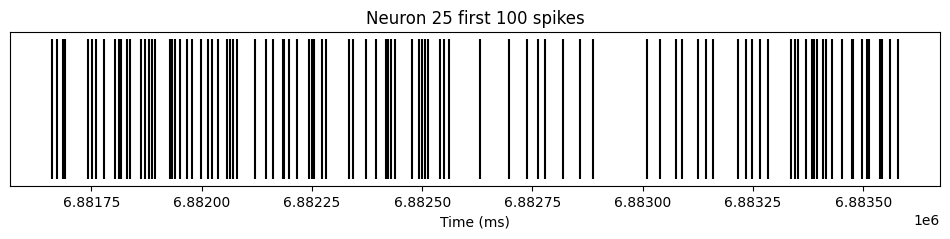

In [16]:
# Plot the first 100 spikes

first_100_spikes = sample_spikes[:100]

fig, ax = plt.subplots(figsize = (12, 2))

ax.vlines(first_100_spikes, ymin = 0, ymax = 1, color = 'black')

ax.set_xlabel('Time (ms)')
ax.set_yticks([])

ax.set_title(f'Neuron {cell_index} first 100 spikes')

plt.show()

In [17]:
# Get firing rate of cell over the whole time series

time_init = trackingtimes[0]
time_fin = trackingtimes[-1]

num_ms_in_whole_recording = time_fin - time_init
num_bins_for_1_second_bins = num_ms_in_whole_recording/1000

firing_rate, _, _ = binned_statistic(x = sample_spikes, values = np.ones_like(sample_spikes),  statistic = 'count', bins = num_bins_for_1_second_bins)

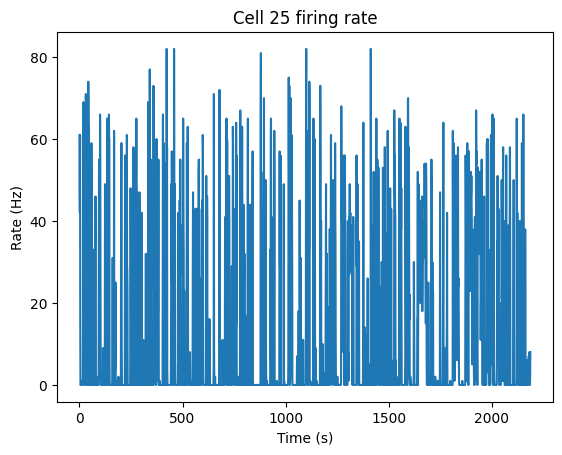

In [18]:
fig, ax = plt.subplots()

ax.plot(range(len(firing_rate)), firing_rate)

ax.set_title(f'Cell {cell_index} firing rate')
ax.set_ylabel('Rate (Hz)')
ax.set_xlabel('Time (s)')
plt.show()

# Make a tuning curve

In [19]:
# Set bins for heading

num_bins = 20

heading_bins = np.linspace(0, 2*np.pi, num_bins + 1)

heading_bins

array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
       4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,
       6.28318531])

In [20]:
# Get time spent in each bin (of headangle)

occupancy_times, _ = np.histogram(headangle, heading_bins)

# Note each tracking time in 25.6ms. So, convert to get occupancy time in seconds
occupancy_times = occupancy_times * 25.6/1000

In [21]:
spikes_in_bin = np.zeros(num_bins)
for spike in sample_spikes:

    # Find the index of the first tracking time after the spike
    idx_after = np.searchsorted(trackingtimes, spike)
    
    # Make sure the spike is bracketed by valid tracking samples
    if 0 < idx_after < len(trackingtimes):
        t_0 = trackingtimes[idx_after - 1]
        t_1 = trackingtimes[idx_after]
        h_0 = headangle[idx_after - 1]
        h_1 = headangle[idx_after]

        if not np.isnan(h_0) and not np.isnan(h_1):
            percent_between_tracking_times = (spike - t_0)/(t_1 - t_0)

            # Interpolate head angle
            headangle_at_spike = (1 - percent_between_tracking_times)*h_0 + percent_between_tracking_times*h_1
            headangle_at_spike %= 2*np.pi



            # Linear interpolation
            w = (spike - t_0) / (t_1 - t_0)
            headangle_at_spike = (1 - w) * h_0 + w * h_1
            headangle_at_spike %= 2 * np.pi  # wrap to [0, 2π)

            # Bin the interpolated head angle
            index_of_right_endpoint_of_heading_bin_at_spike = np.digitize(headangle_at_spike, heading_bins) 
            if 0 < index_of_right_endpoint_of_heading_bin_at_spike <= num_bins:
                spikes_in_bin[index_of_right_endpoint_of_heading_bin_at_spike - 1] += 1
    

In [22]:
# Create tuning curve
tuning_curve = np.zeros((num_bins, 20))

# Set x-axis
tuning_curve[:, 0] = heading_bins[:num_bins]

# Firing rate in Hz is number of spikes/occupancy time, with occupancy time measured in seconds.
tuning_curve[:, 1] = spikes_in_bin/occupancy_times




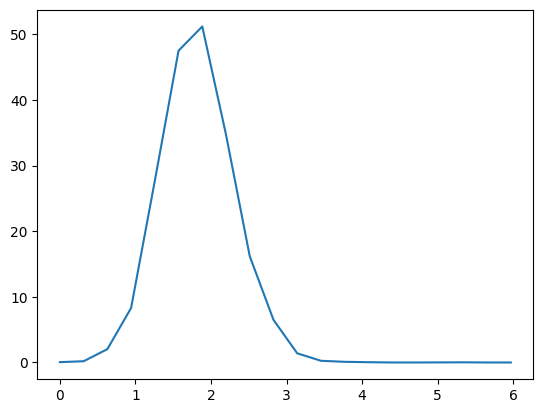

In [23]:
# Plot the tuning curve

fig, ax = plt.subplots()

ax.plot(tuning_curve[:, 0], tuning_curve[:, 1])
plt.show()

In [24]:
# Package this into a function

def get_tuning_curve(spikes, num_bins, trackingtimes, headangle):
    heading_bins = np.linspace(0, 2*np.pi, num_bins + 1)

    # Get time spent in each bin (of headangle)
    occupancy_times, _ = np.histogram(headangle, heading_bins)

    # Note each tracking time in 25.6ms. So, convert to get occupancy time in seconds
    occupancy_times = occupancy_times * 25.6/1000

    spikes_in_bin = np.zeros(num_bins)
    for spike in spikes:

        # Find the index of the first tracking time after the spike
        idx_after = np.searchsorted(trackingtimes, spike)
        
        # Make sure the spike is bracketed by valid tracking samples
        if 0 < idx_after < len(trackingtimes):
            t_0 = trackingtimes[idx_after - 1]
            t_1 = trackingtimes[idx_after]
            h_0 = headangle[idx_after - 1]
            h_1 = headangle[idx_after]

            if not np.isnan(h_0) and not np.isnan(h_1):
                percent_between_tracking_times = (spike - t_0)/(t_1 - t_0)

                # Interpolate head angle
                headangle_at_spike = (1 - percent_between_tracking_times)*h_0 + percent_between_tracking_times*h_1
                headangle_at_spike %= 2*np.pi


                # Bin the interpolated head angle
                index_of_right_endpoint_of_heading_bin_at_spike = np.digitize(headangle_at_spike, heading_bins) 
                if 0 < index_of_right_endpoint_of_heading_bin_at_spike <= num_bins:
                    spikes_in_bin[index_of_right_endpoint_of_heading_bin_at_spike - 1] += 1
    
    # Create tuning curve
    tuning_curve = np.zeros((num_bins, 2))

    # Set x-axis
    tuning_curve[:, 0] = heading_bins[:num_bins]

    # Firing rate in Hz is number of spikes/occupancy time, with occupancy time measured in seconds.
    tuning_curve[:, 1] = spikes_in_bin/occupancy_times

    return tuning_curve






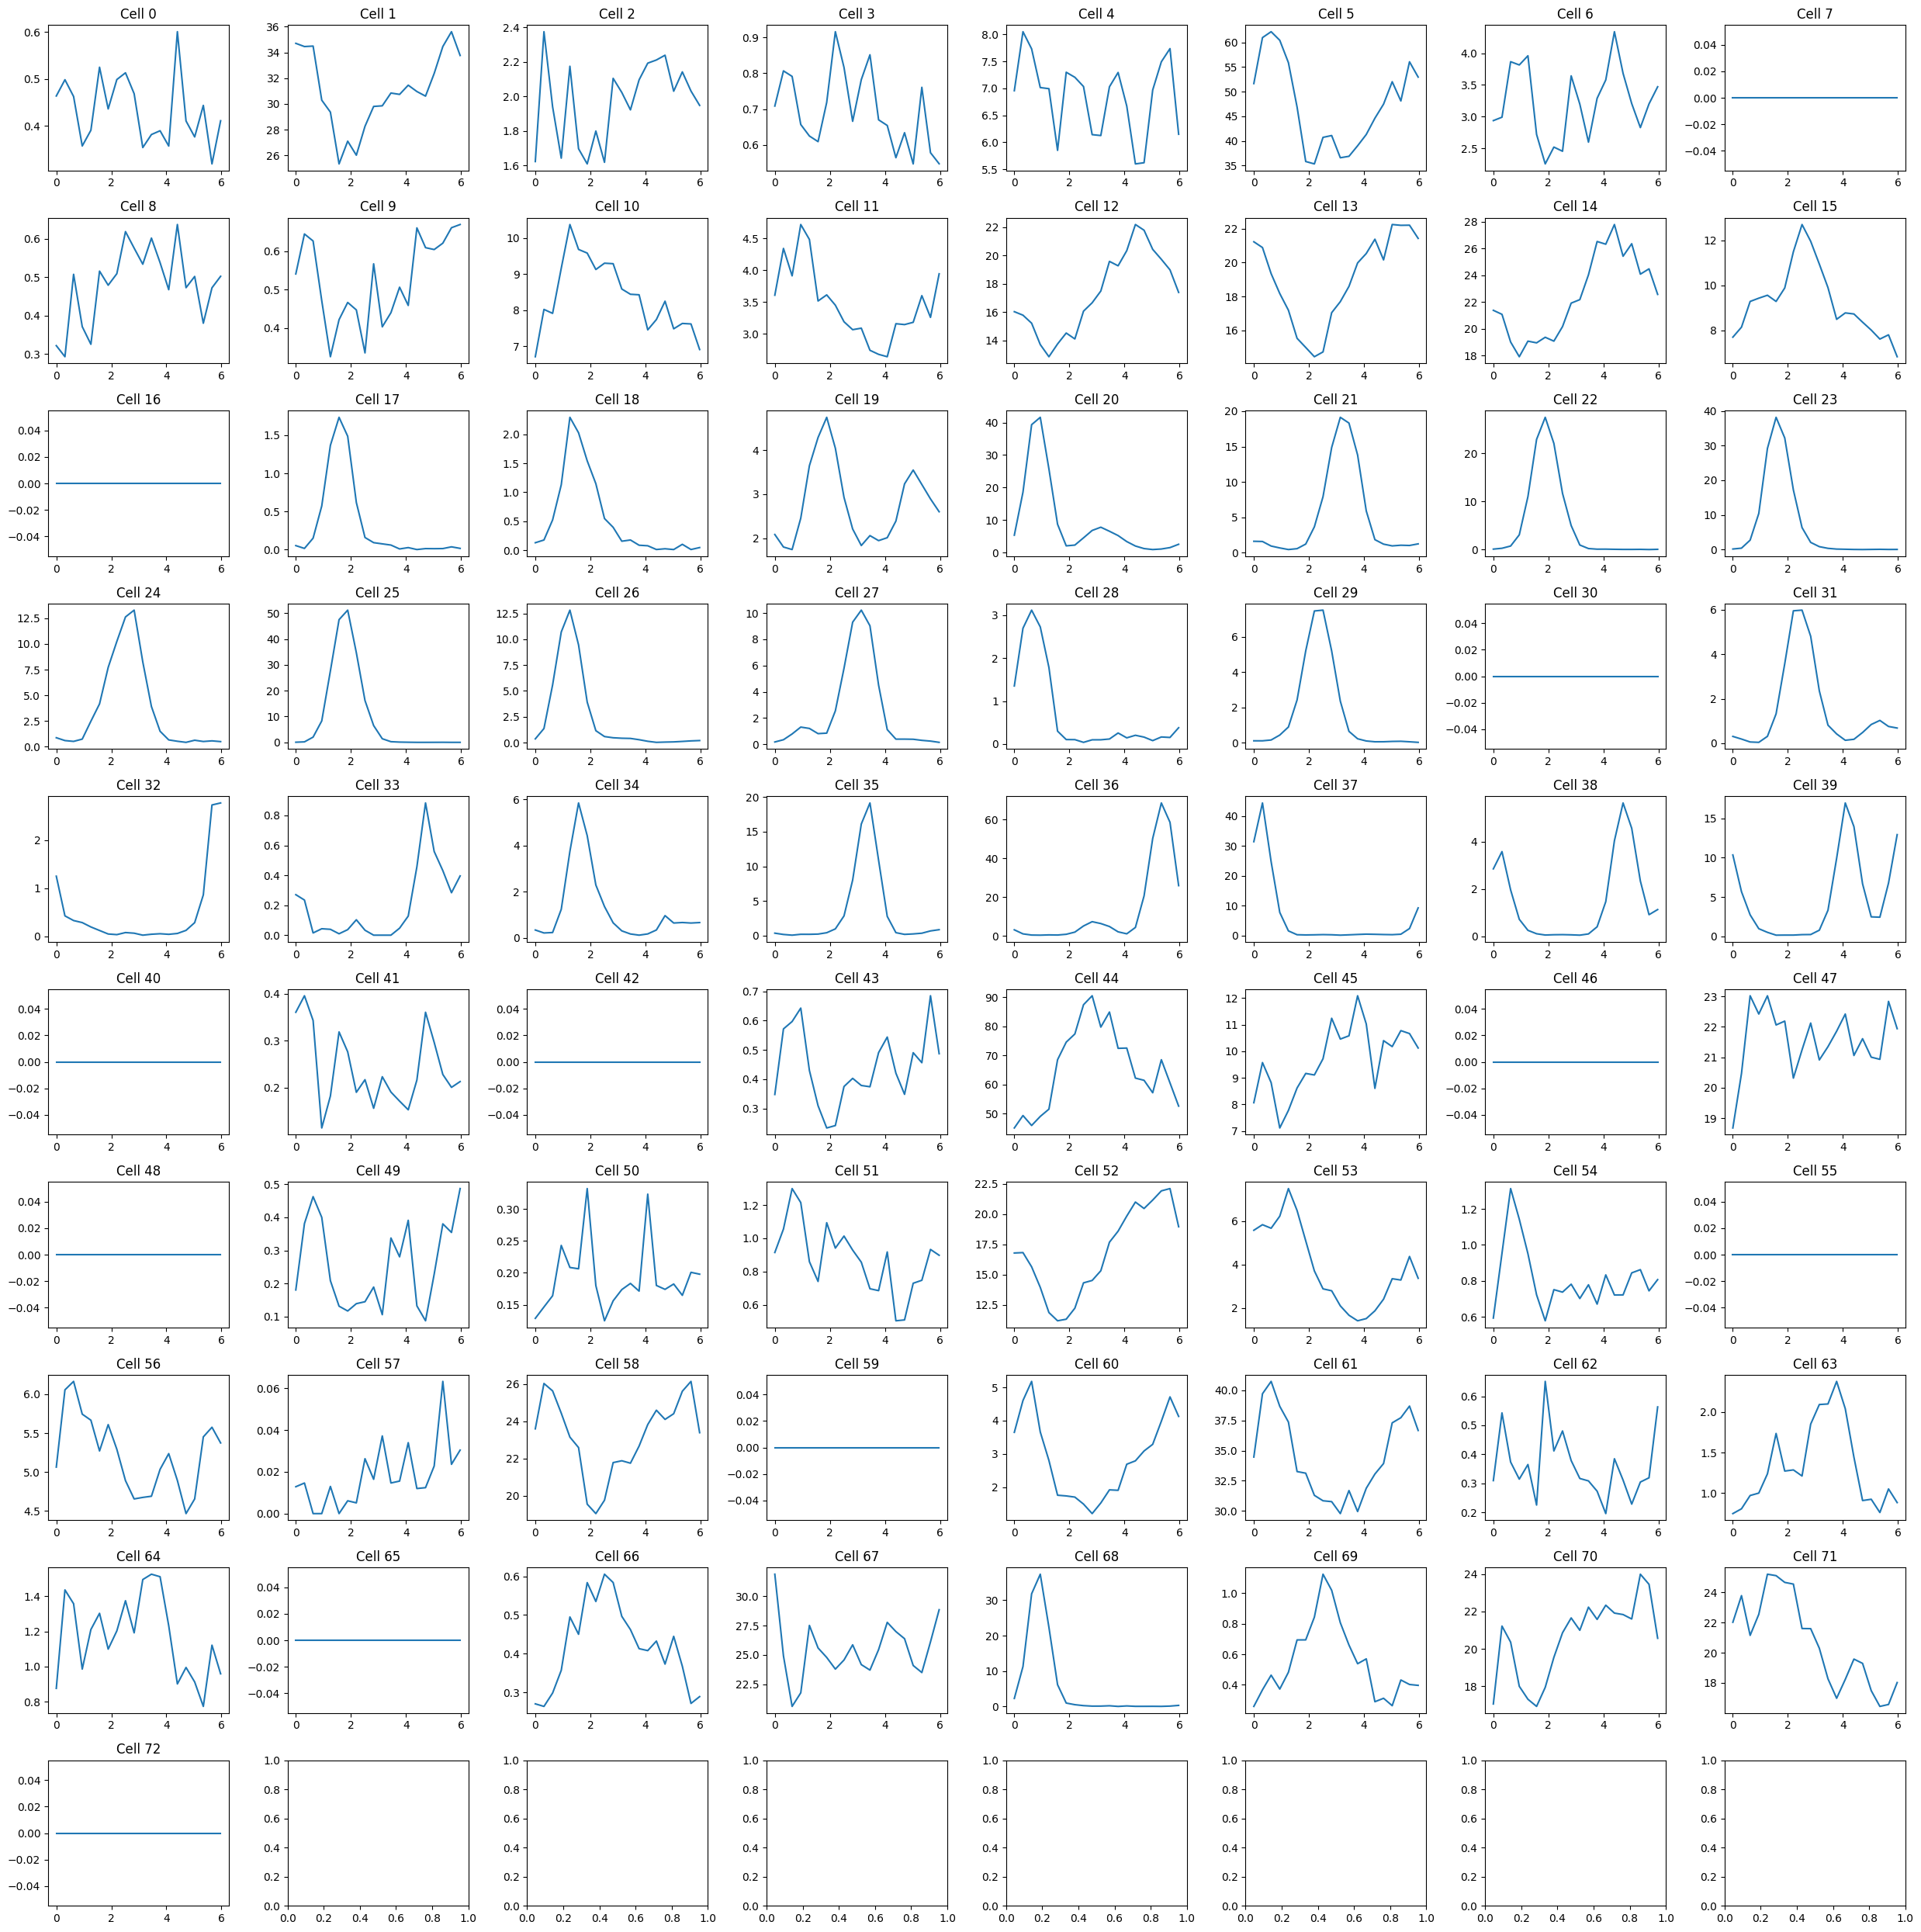

In [25]:
# Plot all tuning curves

tuning_curve_dict = {}

num_rows = 10
num_cols = 8



fig, ax = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (25, 25))


for cell_number in range(73):


    row_index, col_index = np.divmod(cell_number, num_cols)

    try:
        spike_times = cellspikes[cell_number][0]
    except:
        spike_times = np.array([])



    tuning_curve = get_tuning_curve(spike_times, num_bins, trackingtimes, headangle)

    ax[row_index, col_index].plot(tuning_curve[:, 0], tuning_curve[:, 1])
    ax[row_index, col_index].set_title(f'Cell {cell_number}')

    tuning_curve_dict[cell_number] = tuning_curve



plt.tight_layout()
plt.show()

# Do topology!

In [26]:
# For uniformity, let's normalize max rates to 50 Hz
# Also, to work with an old function we're going to treat the circle as R/Z = [0, 1]/(0 ~ 1) rather than [0, 2pi)

for _, tuning_curve in tuning_curve_dict.items():
    max = np.max(tuning_curve[:, 1])
    if max != 0:
        tuning_curve[:, 1] = 50 * tuning_curve[:, 1] / max
    tuning_curve[:, 0] = tuning_curve[:, 0]/(2*np.pi)

In [27]:
def calculate_firing_rate_from_tuning_curve(position, tuning_curve_array):
    """
    Parameters
    ----------
    position : float
        Number in [0, 1) representing a position on the circle S^1 = R/Z
    
    tuning_curve_array : numpy array 
        Tuning curve of a neuron on a circle represented as R/Z. First column should be x positions (in [0,1)) and second column should be firing rates

    
    Returns
    ----------
    rate : float
        Firing rate at givin position
    
    """
    if position < 0 or position >= 1:
        raise Exception('Invalid position.')
    num_positions = tuning_curve_array.shape[0]

    # Handle edge case where we run into 0~1 identification
    if position >= tuning_curve_array[num_positions - 1, 0] or position <= tuning_curve_array[0, 0]:
        x_1 = tuning_curve_array[num_positions - 1, 0]
        y_1 = tuning_curve_array[num_positions - 1, 1]
        x_2 = tuning_curve_array[0, 0] + 1
        y_2 = tuning_curve_array[0, 1]
        slope = (y_2 - y_1)/(x_2 - x_1)
        if position <= tuning_curve_array[0, 0]:
            rate = slope*((position + 1) - x_1) + y_1
            return rate
        else:
            rate = slope*((position) - x_1) + y_1
            return rate
    
    # Otherwise, just linearly interpolate
    else:
        index = np.searchsorted(tuning_curve_array[:, 0], position) - 1
        x_1 = tuning_curve_array[index, 0]
        y_1 = tuning_curve_array[index, 1]
        x_2 = tuning_curve_array[index + 1, 0]
        y_2 = tuning_curve_array[index + 1, 1]
        slope = (y_2 - y_1)/(x_2 - x_1)
        rate = slope*(position - x_1) + y_1
        return rate
    


def calculate_response_matrix_given_walk_on_circle_and_tuning_curves(path_on_circle, tuning_curves):
    """
    Parameters
    ----------
    path_on_circle : numpy array of shape (num_steps, )
        A path on a circle R/Z, consisting of values in [0, 1)

    tuning_curves : dict
        A dictionary of num_neurons (neuron_index, tuning_curve)-pairs


    Returns
    ----------
    response_matrix : numpy array of shape (num_neurons, num_steps)
        Row i is neuron i's response to the `path_on_circle` as a time series
    """

    num_steps = len(path_on_circle)
    num_neurons = len(tuning_curves.keys())
    response_matrix = np.zeros((num_neurons, num_steps))
    for neuron_index in range(num_neurons):
        tuning_curve = tuning_curves[neuron_index]
        for step_index in range(num_steps):
            response_matrix[neuron_index, step_index] = calculate_firing_rate_from_tuning_curve(path_on_circle[step_index], tuning_curve)
    return response_matrix


def add_normal_random_noise(matrix, integer_seed, nonzero_entry_std_dev_factor, min_std_dev):
    """
    Parameters
    ----------
    matrix : numpy array
        Represents popoulationa activity

    integer_seed : int
        Seed for random functions

    nonzero_entry_std_dev_factor : float
        Standard deviation parameter to draw noise for nonzero entries

    min_std_dev : float
        Minimum standard deviation for noise (for zero entries)

    
    Returns
    ---------
    noisy_matrix : numpy array of same shape as `matrix`
        Is `matrix` with added Gaussian noise
    """
    np.random.seed(integer_seed)

    noisy_matrix = matrix.copy()

    noisy_matrix = np.maximum(0, np.random.normal(noisy_matrix, np.maximum(nonzero_entry_std_dev_factor*noisy_matrix, min_std_dev)))

    return noisy_matrix


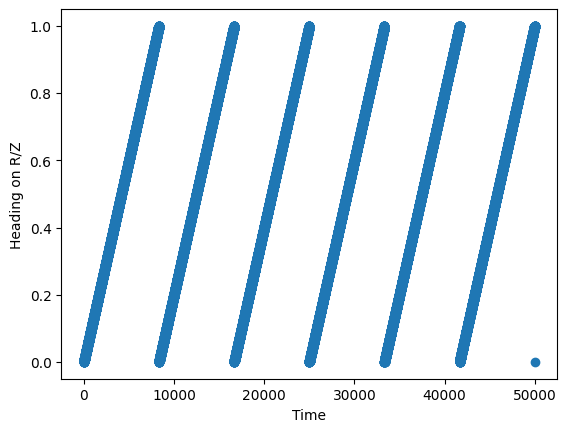

In [28]:
# Let's have our mouse turn around seven times

circular_positions = np.linspace(1, 7, 50000) % 1

fig, ax = plt.subplots()

ax.scatter(range(len(circular_positions)), circular_positions)
ax.set_xlabel('Time')
ax.set_ylabel('Heading on R/Z')
plt.show()
    

In [29]:
# Get response and add noise

response_matrix = calculate_response_matrix_given_walk_on_circle_and_tuning_curves(circular_positions, tuning_curve_dict)
response_matrix = add_normal_random_noise(response_matrix, 2, .05, 2.5)

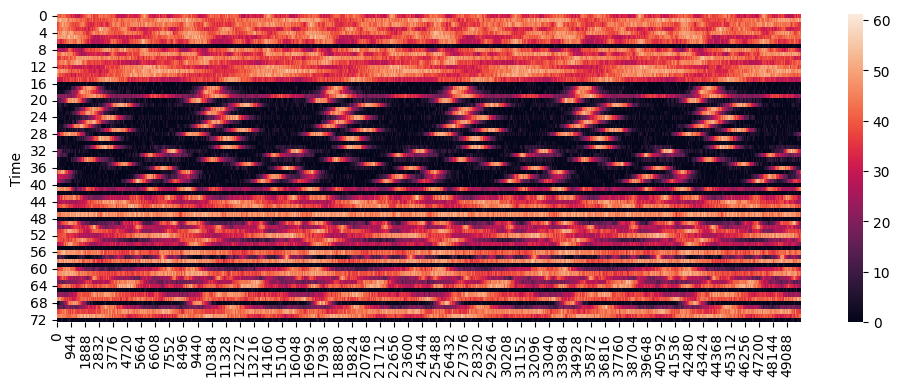

In [33]:
# Plot response matrix

fig, ax = plt.subplots(figsize = (12, 4))

sns.heatmap(response_matrix, ax = ax)

ax.set_ylabel('Neuron')
ax.set_ylabel('Time')

plt.show()

In [34]:
# Compute correlation among neurons and turn into dissimilarity matrix with values normalized between 0 and 1

correlation = np.corrcoef(response_matrix)

dissimilarity_matrix = 1 + correlation
dissimilarity_matrix /= np.max(dissimilarity_matrix)
dissimilarity_matrix = 1 - dissimilarity_matrix

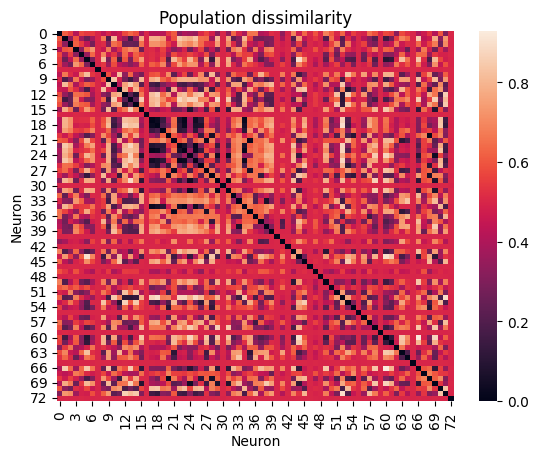

In [35]:
# Plot heatmap of dissimilarity matrix

fig, ax = plt.subplots()



ax.set_title('Population dissimilarity')
sns.heatmap(dissimilarity_matrix, ax = ax)
ax.set_xlabel('Neuron')
ax.set_ylabel('Neuron')
plt.show()

In [36]:
# Do Ripser calculation

result = ripser(dissimilarity_matrix, distance_matrix = True)

In [37]:
# Get dimension 1 barcode

dim_1_barcode = result['dgms'][1]

In [38]:

def plot_n_longest_bars(array, n, title = None):
    # Sort the array based on the width of the bars (x_end - x_start)
    sorted_array = sorted(array, key=lambda x: x[1] - x[0], reverse=True)
    
    # Take the first n rows from the sorted array
    n_longest_bars = sorted_array[:n]

    # Sort by birthtime
    n_longest_bars = sorted(n_longest_bars, key = lambda x: x[0], reverse = True)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot each of the n longest bars
    for i in range(len(n_longest_bars)):
        x_start, x_end = n_longest_bars[i]
        width = x_end - x_start
        ax.hlines(i, x_start, x_end, linewidth=5, color='black')
    
    # Set plot limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, len(n_longest_bars))
    ax.set_xlabel('')
    ax.set_title('')
    
    # Hide y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Hide x-axis ticks and labels
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    
    # Show grid lines
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    plt.xticks(np.arange(0, 1.1, 0.1))

    ax.set_title(title)
    
    # Show the plot
    plt.show()


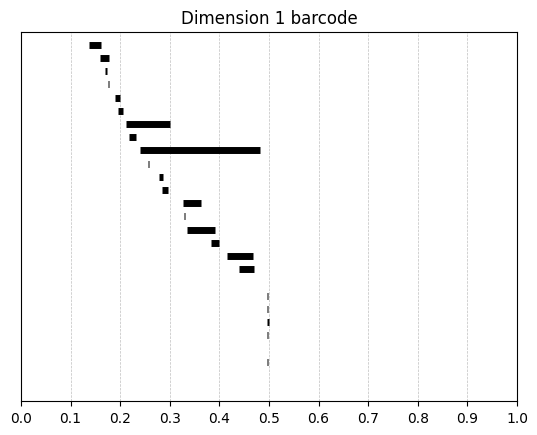

In [39]:
# Plot the barcode

plot_n_longest_bars(dim_1_barcode, 100, title = 'Dimension 1 barcode')